In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import ipywidgets as widgets

In [10]:
# Read the data file.
input_file = 'carsalesdata.csv'
df = pd.read_csv(input_file)

In [11]:
# Strip extra white space in name column.
df['Name'] = df['Name'].str.strip()
# Seperate the name into make and model of vehicle and merge it back into the table.
make_model = df['Name'].str.split(' ', n=1, expand=True)
df.insert(0, 'Make', make_model[0])
df.insert(1, 'Model', make_model[1])
df.drop(columns='Name', inplace=True)
# Seperate model numbers from the years.
tempmd = df['Year'].apply(str)
tempmd = tempmd.str.slice(start=4)
tempmd2 = df['Model'].str.cat(tempmd, na_rep='')
df['Model'] = tempmd2.str.strip()
# Fix the years by removing the model numbers.
tempmd = df['Year'].apply(str)
tempmd = tempmd.str.slice(stop=4)
df['Year'] = tempmd.apply(int)

In [12]:
# Make an array of models from make.
car_makes = df['Make'].unique()
car_makes.sort()
# Make an empty array for models to be stored with make.
car_models = [[]*1 for i in range(len(car_makes))]
for i in range(len(car_makes)):
    make_name = car_makes.item(i)
    car_models[i].insert(0, make_name)
    temp_list = df.loc[df['Make'] == make_name].Model.unique()
    temp_list.sort()
    car_models[i].extend(temp_list.tolist())
# Remember num of makes: len(car_models), num of models: len(car_models[# of bin])-1 (Make occupies bin 0).
# Make years into a list for dropdown.
years=df['Year'].unique()
years.sort()
years=years.tolist()

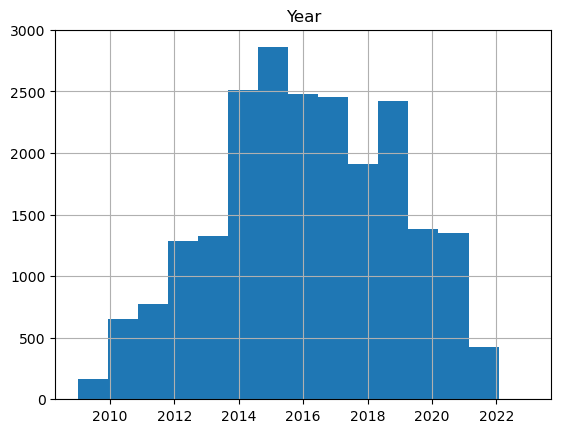

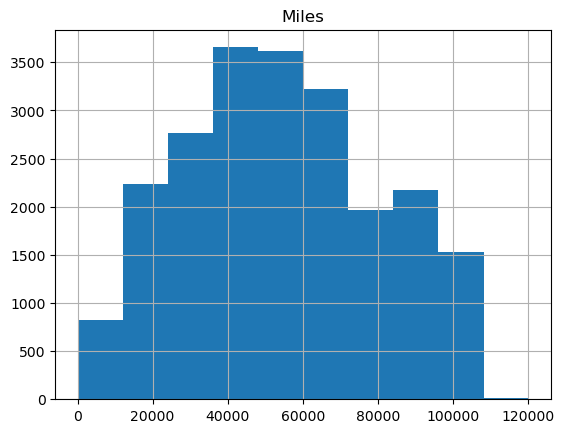

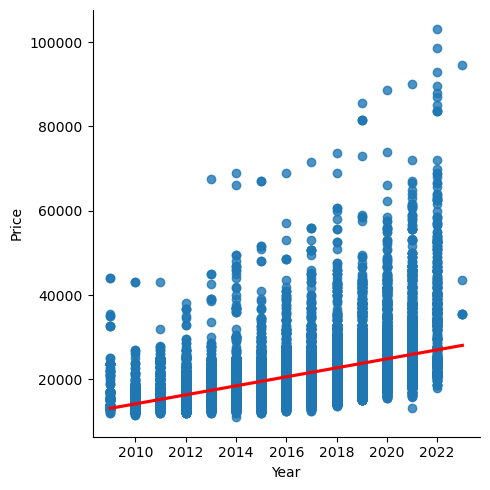

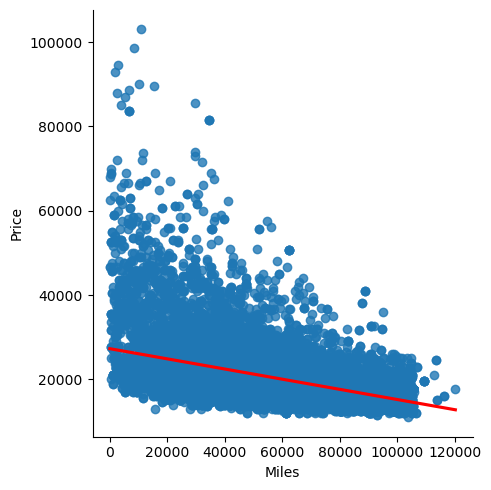

In [22]:
# Make the vehicle makes and models into binary data for training purposes.
makebinaries = pd.get_dummies(df['Make'], prefix='make')
modelbinaries = pd.get_dummies(df['Model'], prefix='model')
df_original = df
df = pd.concat([df, makebinaries], axis=1)
df = pd.concat([df, modelbinaries], axis=1)
#Empty dataframe with binary make and model
df_structure=df.drop(df.index).copy()
# Remove duplicate columns
# df = df.loc[:,~df.columns.duplicated()].copy()
# df_structure=df.drop(df.index).copy()

df.hist(column='Year',bins=len(df['Year'].unique()))
df.hist(column='Miles')
year_price_plot=sns.lmplot(data=df_original,x='Year',y='Price',fit_reg=True,order=1,line_kws={'color':'red'})
miles_price_plot2=sns.lmplot(data=df_original,x='Miles',y='Price',fit_reg=True,order=1,line_kws={'color':'red'})

#List to store details for new predictions.
carList=[]
# Function to make a prediction from the model.
def make_prediction(carList):
    #Columns: Make, Model, Year, Miles, Price
    new_car_pred=df_structure
    car_make='make_'+carList[0]
    car_model='model_'+carList[1]
    carList[0]=1
    carList[1]=1
    new_car=pd.DataFrame([carList],columns=[car_make,car_model,'Year','Miles','Price'])
    new_car_pred=pd.concat([new_car_pred,new_car])
    new_car_pred.merge(new_car)
    new_car_pred=new_car_pred.fillna(0)
    new_car_pred=new_car_pred.drop(['Make','Model', 'Price'], axis=1)
    new_car_pred=scaler.transform(new_car_pred)
    carList.clear()
    return model.predict(new_car_pred)

Mean Absolute Error: 1304.4971
Mean Absolute Percentage Error: 0.0594
Root Mean Squared Error: 2480.9614
R2 Score: 0.8533


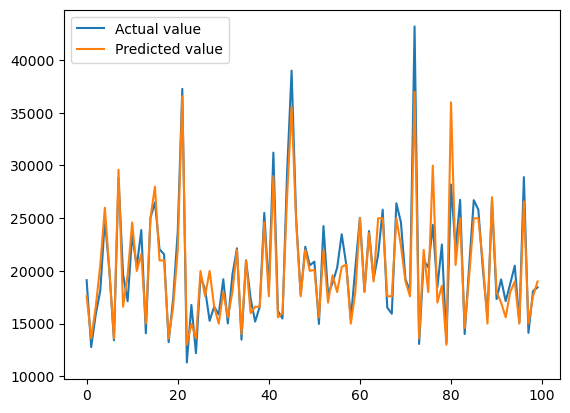

In [14]:
# Make the test and training datasets.
X = df.drop(['Make','Model', 'Price'], axis=1)
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Make the model using ridge regression.
model=Ridge()
model.fit(X_train, y_train)
#print('coefficients : ', model.coef_)
y_pred = model.predict(X_test)
# Print the accuracy information.
print("Mean Absolute Error: %.4f" % mean_absolute_error(y_test, y_pred))
print("Mean Absolute Percentage Error: %.4f" % mean_absolute_percentage_error(y_test, y_pred))
print('Root Mean Squared Error: %.4f' %
      mean_squared_error(y_test, y_pred, squared=False))
print("R2 Score: %.4f" % r2_score(y_test, y_pred))

# Plot prediction data vs actual value from the test data.
test = pd.DataFrame({'Predicted value': y_pred, 'Actual value': y_test})
fig = plt.figure()
test = test.reset_index()
test = test.drop(['index'], axis=1)
plt.plot(test[:100])
plt.legend(['Actual value', 'Predicted value'])
plt.show()

In [21]:
# Create vehicle make dropdown widget.
make_dropdown=widgets.Dropdown(
    options=car_makes.tolist(),
    value=None,
    description='Car Make: ',
    disabled=False,
)
# Create vehicle year dropdown widget.
year_dropdown=widgets.Dropdown(
    options=years,
    description='Year: ',
    disabled=False,
)
# Create vehicle model dropdown widget.
selected_models=[]
model_dropdown=widgets.Dropdown(
    options=selected_models,
    value=None,
    description='Model: ',
    disabled=False,
)
# Load matching models to the make in the dropdown.
def handle_make_dropdown_change(change):
    for i in range(len(car_models)):
        if car_models[i][0]==make_dropdown.value:
            selected_models=car_models[i].copy()
    # First item in list is the make.
    selected_models.pop(0)
    model_dropdown.options=selected_models
make_dropdown.observe(handle_make_dropdown_change, names='value')
# Create vehicle mileage text widget.
mileage_textbox=widgets.BoundedIntText(
    value=10000,
    min=50,
    max=125000,
    step=1,
    description='Mileage: ',
    disabled=False
)
# Create predicted price display widget.
price_label=widgets.Label(
    style=dict(font_weight='bold')
)
# Create the process button widget.
process_button=widgets.Button(
    description='Calculate',
    disabled=False,
    icon='car-side'
)
# Define the button action. This takes the all the values from the widgets and makes it into a list item representing a vehicle.
def process_button_action(b):
    global carList
    #price_label.value='Price: '+str(random.randint(0,100))
    if ((make_dropdown.value==None)|(model_dropdown.value==None)):
        price_label.value='Make or model is missing. Please check and try again.'
    else:
        carList.clear()
        carList.append(make_dropdown.value)
        carList.append(model_dropdown.value)
        carList.append(year_dropdown.value)
        carList.append(mileage_textbox.value)
        #Adding 1000 for price as its unknown, estimated base price.
        carList.append('1000')
        car_price=np.array2string(make_prediction(carList),precision=0)
        car_price=car_price.lstrip('[').rstrip(']')
        car_price="${:,.2f}".format(float(car_price))
        price_label.value=str(year_dropdown.value)+' '+make_dropdown.value+' '+model_dropdown.value+' '+' price is: '+car_price

# Create vehicle make dropdown widget.
process_button.on_click(process_button_action)
# Create vehicle make dropdown widget.
display(year_dropdown,make_dropdown,model_dropdown,mileage_textbox,process_button,price_label)

Dropdown(description='Year: ', options=(2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020…

Dropdown(description='Car Make: ', options=('Acura', 'Alfa', 'Audi', 'BMW', 'Buick', 'Cadillac', 'Chevrolet', …

Dropdown(description='Model: ', options=(), value=None)

BoundedIntText(value=10000, description='Mileage: ', max=125000, min=50)

Button(description='Calculate', icon='car-side', style=ButtonStyle())

Label(value='', style=LabelStyle(font_weight='bold'))